### CO543 Image Processing

#### E/20/280

## Lab 07
# Convolutional Neural Networks

*   **Fine-tuning** uses the pre-trained model as a base and retrains it on a new dataset with a very
small learning rate to adapt it to a new task. This process involves adjusting the weights of the
pre-trained model slightly to suit the new data.
*  **Feature extraction**, on the other hand, treats the pre-trained model as a fixed feature extractor. In
this approach, the model's learned features are used as they are, and only the final classification
layer is replaced and trained on the new dataset.


## Why Use Transfer Learning?
- Reduced Training Time: Transfer learning utilizes pre-trained models, significantly cutting down
the time required to train a model for a new task, as opposed to training from scratch.
- Improved Performance with Limited Data: Deep learning models typically require large datasets
for effective training. Transfer learning leverages knowledge from a pre-trained model on a large
dataset, improving performance even with limited task-specific data.
- Reduced Computational Resources: Utilizing a pre-trained model reduces the computational
resources needed for training, which is beneficial when hardware resources are limited.
- Faster Experimentation: Starting with a pre-trained model allows for rapid experimentation with
different model architectures and fine-tuning for specific needs, accelerating the development
process.

# **Task 1 Transfer learnning**

# Step 1: Install the necessary libraries

In [ ]:
pip install torch torchvision

# Step 2: Import required libraries and their functions

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# from torchsummary import summary

importing pre-processed mnist

# Step 3: Load and Preprocess the MNIST Dataset

In [4]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Why these transformations?
- **Resizing to 224x224**: VGG16, ResNet18, and AlexNet expect **224x224 RGB** images.
- **Grayscale to 3-channel RGB**: MNIST images are grayscale (1-channel), but pre-trained models expect 3 channels.
- **ToTensor()**: Converts images into PyTorch tensors.
- **Normalization**: Helps in stable training by bringing pixel values to a standard range.


In [5]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [03:05<00:00, 53556.82it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 37669.02it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:19<00:00, 83910.36it/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 779513.43it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



- ***shuffle=True***: Ensures random shuffling of training data to avoid biases.
- ***batch_size=32***: Number of images processed at a time.


Normalization of input data, such as using Normalize(mean=[0.5], std=[0.5]), is crucial. This step
involves subtracting the mean and dividing by the standard deviation of the dataset, which speeds up the
training process by standardizing the input values.
Transforming input data to a suitable form and scale for efficient processing by the model is also essential
for the effective training and testing of deep learning models on image datasets.
The reason why we resize is because the model we are using for the task which is VGG16 is trained on
224x 224 images. ToTensor() is used to transform 0-255 discrete values into 0-1 values which are
easier to work with neural networks.

# Step 4: Load the Pre-trained ResNet18 & AlexNet

### **ResNet18 Model**

**resnet18**

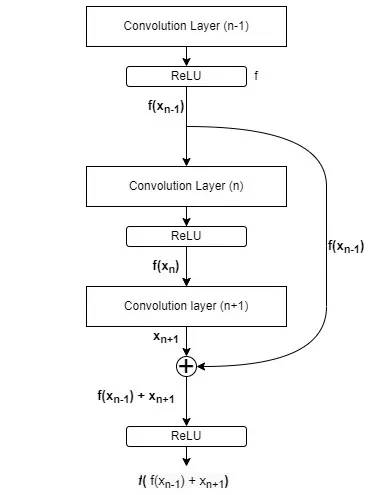

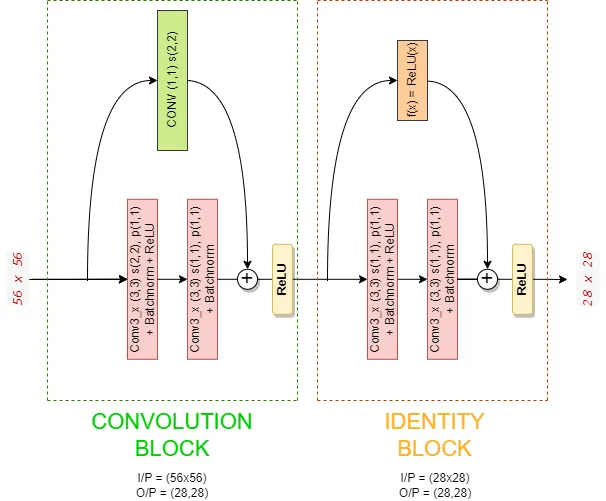

**Architecture**: ResNet18 is part of the ResNet (Residual Network) family and consists of 18 layers: 17 convolutional layers followed by a fully connected layer.

**Depth**: Deeper than AlexNet, with a focus on residual learning.

**Performance**: Known for its ability to train very deep networks without the vanishing gradient problem, achieving state-of-the-art results in various tasks.

**Parameters**: ResNet18 has around 11.7 million parameters.

**Activation Function**: Uses ReLU activation function.

**Normalization**: Uses Batch Normalization.

In [6]:
class MNISTResNet(nn.Module):
    def __init__(self):
        super(MNISTResNet, self).__init__()
        self.resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust input layer
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, 10)  # Modify output layer for 10 classes

    def forward(self, x):
        return self.resnet18(x)

#### **Understanding ResNet18**
- **Conv2d(3, 64, kernel_size=7, stride=2, padding=3)**: The first convolutional layer expects 3-channel input.
- **Skip connections**: ResNet18 has residual connections that help prevent vanishing gradients.
- **Modified output layer**: We replace the final fully connected layer to classify 10 digits.

In [7]:
resnet_model = MNISTResNet()
# summary(resnet_model, (3, 224, 224))

### **AlexNet Model**

**AlexNet**

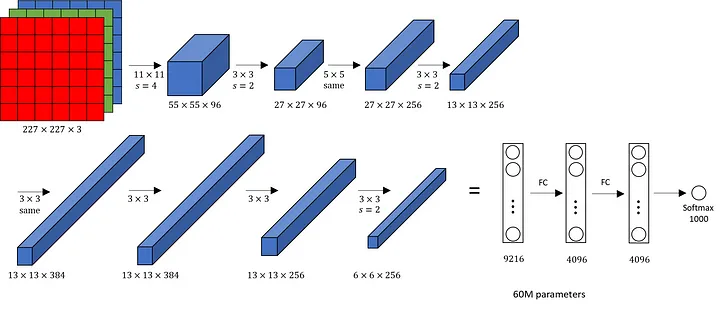



**Architecture**: AlexNet consists of 8 layers: 5 convolutional layers followed by 3 fully connected layers.

**Depth**: AlexNet is relatively shallow compared to modern architectures.

**Performance**: It was revolutionary in 2012, winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) with a top-5 error rate of 15.3%.

**Parameters**: AlexNet has around 60 million parameters.

**Activation Function**: Uses ReLU (Rectified Linear Unit) activation function.

**Normalization**: Implements Local Response Normalization (LRN).

In [10]:
class MNISTAlexNet(nn.Module):
    def __init__(self):
        super(MNISTAlexNet, self).__init__()
        self.alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
        num_ftrs = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_ftrs, 10)  # Change final layer

    def forward(self, x):
        return self.alexnet(x)


**Understanding AlexNet**
- **Uses 5 convolutional layers followed by fully connected layers.**
- **Simpler than ResNet**, without residual connections.

In [9]:
alexnet_model = MNISTAlexNet()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/ravindu/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [21:41<00:00, 188kB/s]    


# Step 5: Define the Loss Function and optimizer and initialize the model

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy


- **CrossEntropyLoss**: Used for multi-class classification.
- **Adam Optimizer**: Adaptive learning rate optimization.

# Step 6: Train the Model and Evaluate the Model

#### Training ResNet18
 

In [15]:
resnet_model = MNISTResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

print("Training ResNet18...")
train_model(resnet_model, train_loader, criterion, optimizer, num_epochs=10)
print("Evaluating ResNet18...")
evaluate_model(resnet_model, test_loader)


Training ResNet18...
Epoch [1/10], Loss: 0.0811
Epoch [2/10], Loss: 0.0407
Epoch [3/10], Loss: 0.0340
Epoch [4/10], Loss: 0.0281
Epoch [5/10], Loss: 0.0225
Epoch [6/10], Loss: 0.0203
Epoch [7/10], Loss: 0.0162
Epoch [8/10], Loss: 0.0139
Epoch [9/10], Loss: 0.0117
Epoch [10/10], Loss: 0.0103
Evaluating ResNet18...
Accuracy: 99.04%


99.04

In [16]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f'Model saved as {filename}')


In [55]:
def load_model(model_class, filename):
    model = model_class().to(device)
    model.load_state_dict(torch.load(filename))
    model.eval()  # Set to evaluation mode
    print(f'Model loaded from {filename}')
    return model

In [17]:
# Save ResNet18 Model
save_model(resnet_model, "resnet18_mnist.pth")

Model saved as resnet18_mnist.pth


#### Training AlexNet

In [18]:
alexnet_model = MNISTAlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=0.001)

print("Training AlexNet...")
train_model(alexnet_model, train_loader, criterion, optimizer, num_epochs=10)
print("Evaluating AlexNet...")
evaluate_model(alexnet_model, test_loader)


Training AlexNet...
Epoch [1/10], Loss: 0.4430
Epoch [2/10], Loss: 0.1685
Epoch [3/10], Loss: 0.1428
Epoch [4/10], Loss: 0.1391
Epoch [5/10], Loss: 0.1370
Epoch [6/10], Loss: 0.1355
Epoch [7/10], Loss: 0.1484
Epoch [8/10], Loss: 0.1239
Epoch [9/10], Loss: 0.1096
Epoch [10/10], Loss: 0.1213
Evaluating AlexNet...
Accuracy: 98.80%


98.8

In [19]:
# Save AlexNet Model
save_model(alexnet_model, "alexnet_mnist.pth")

Model saved as alexnet_mnist.pth


### Comparison of AlexNet and ResNet18  

- **Architecture**:  
  - **AlexNet**: Sequential with 5 convolutional layers and fully connected layers.  
  - **ResNet18**: Deeper with residual (skip) connections for better gradient flow.  

- **Parameters & Efficiency**:  
  - **AlexNet**: ~60 million parameters, computationally heavy.  
  - **ResNet18**: ~11 million parameters, more optimized and efficient.  

- **Training & Performance**:  
  - **AlexNet**: Susceptible to vanishing gradients in deeper versions.  
  - **ResNet18**: Skip connections allow better gradient propagation and training stability.  

- **Transfer Learning**:  
  - **AlexNet**: Less effective due to its shallow structure.  
  - **ResNet18**: Retains fine-grained features better, making it more useful for transfer learning.

# **Lab Task 2: Impact of Hyperparameters**

### 1. Model A

In [ ]:
class ModelA(nn.Module):
    def __init__(self):
        super(ModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)  # Change from 1 to 3 channels
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(8 * 112 * 112, 64) # input size, output size
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x



## Model A Data Flow

1.  **Input:**
    * Shape: `(batch_size, 3, 224, 224)` (e.g., `(32, 3, 224, 224)`)
    * Description: Batch of MNIST images, resized to 224x224, 3 channels.

2.  **`conv1`:**
    * `nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)`
    * Input Channels: 3
    * Output Channels: 8
    * Kernel Size: 3x3
    * Stride: 1
    * Padding: 1
    * Shape: `(batch_size, 8, 224, 224)`

3.  **`ReLU`:**
    * Shape: `(batch_size, 8, 224, 224)`
    * Description: Applies ReLU activation.

4.  **`pool`:**
    * `nn.MaxPool2d(kernel_size=2, stride=2)`
    * Kernel Size: 2x2
    * Stride: 2
    * Shape: `(batch_size, 8, 112, 112)`

5.  **`x.view(x.size(0), -1)`:**
    * Shape: `(batch_size, 8 * 112 * 112)` = `(batch_size, 100352)`
    * Description: Flattens the feature maps.

6.  **`fc1`:**
    * `nn.Linear(100352, 64)`
    * Input Features: 100352
    * Output Features: 64
    * Shape: `(batch_size, 64)`

7.  **`ReLU`:**
    * Shape: `(batch_size, 64)`
    * Description: Applies ReLU activation.

8.  **`fc2`:**
    * `nn.Linear(64, 10)`
    * Input Features: 64
    * Output Features: 10
    * Shape: `(batch_size, 10)`

9.  **Output:**
    * Shape: `(batch_size, 10)`
    * Description: Logits for each class.



How it works:

1. The first convolutional layer extracts simple patterns (edges, textures) from the input images.
2. Max pooling reduces the size and keeps important features.
3. The output is flattened and passed through two fully connected layers, where:
- fc1: Extracts high-level features.
- fc2: Outputs 10 class probabilities.

Use Case:

- This is a lightweight CNN useful for small datasets like MNIST or CIFAR-10.
- However, it is limited in capturing deep features compared to transfer learning models.


### 2. Model B

In [51]:
class ModelB(nn.Module):
    def __init__(self):
        super(ModelB, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1) # Change to 3 channels
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 56 * 56, 64) # corrected
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Model B Data Flow

1.  **Input:**
    * Shape: `(batch_size, 3, 224, 224)`
    * Description: Batch of MNIST images, resized to 224x224, 3 channels.

2.  **`conv1`:**
    * `nn.Conv2d(3, 8, kernel_size=3, padding=1)`
    * Input Channels: 3
    * Output Channels: 8
    * Kernel Size: 3x3
    * Padding: 1
    * Shape: `(batch_size, 8, 224, 224)`

3.  **`ReLU`:**
    * Shape: `(batch_size, 8, 224, 224)`
    * Description: Applies ReLU activation.

4.  **`pool`:**
    * `nn.MaxPool2d(kernel_size=2, stride=2)`
    * Shape: `(batch_size, 8, 112, 112)`

5.  **`conv2`:**
    * `nn.Conv2d(8, 16, kernel_size=3, padding=1)`
    * Input Channels: 8
    * Output Channels: 16
    * Kernel Size: 3x3
    * Padding: 1
    * Shape: `(batch_size, 16, 112, 112)`

6.  **`ReLU`:**
    * Shape: `(batch_size, 16, 112, 112)`
    * Description: Applies ReLU activation.

7.  **`pool`:**
    * `nn.MaxPool2d(kernel_size=2, stride=2)`
    * Shape: `(batch_size, 16, 56, 56)`

8.  **`x.view(x.size(0), -1)`:**
    * Shape: `(batch_size, 16 * 56 * 56)` = `(batch_size, 50176)`
    * Description: Flattens the feature maps.

9.  **`fc1`:**
    * `nn.Linear(50176, 64)`
    * Input Features: 50176
    * Output Features: 64
    * Shape: `(batch_size, 64)`

10. **`ReLU`:**
    * Shape: `(batch_size, 64)`
    * Description: Applies ReLU activation.

11. **`fc2`:**
    * `nn.Linear(64, 10)`
    * Input Features: 64
    * Output Features: 10
    * Shape: `(batch_size, 10)`

12. **Output:**
    * Shape: `(batch_size, 10)`
    * Description: Logits for each class.

How it works:

1. First convolutional layer learns basic edges.
2. Second convolutional layer learns more complex patterns.
3. Max pooling after both convolutions ensures reduced dimensionality while keeping key features.
4. Fully connected layers classify the image into one of 10 categories.

Differences from Model A:

- Deeper network → Can learn more complex patterns.
- More parameters → More compute-intensive.

Use Case:

- Suitable for small datasets but more powerful than Model A.
- Can generalize better if trained on a diverse dataset.


### 3. Train and Evaluate Model A and Model B

In [52]:
def train_simple_model(model, train_loader, optimizer, num_epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training Model A...")
model_a = ModelA().to(device)
optimizer_a = optim.Adam(model_a.parameters(), lr=0.001)
train_simple_model(model_a, train_loader, optimizer_a, num_epochs=10)

print("Training Model B...")
model_b = ModelB().to(device)
optimizer_b = optim.Adam(model_b.parameters(), lr=0.001)
train_simple_model(model_b, train_loader, optimizer_b, num_epochs=10)

Training Model A...
Epoch [1/10], Loss: 0.3515
Epoch [2/10], Loss: 0.1942
Epoch [3/10], Loss: 0.1366
Epoch [4/10], Loss: 0.0952
Epoch [5/10], Loss: 0.0707
Epoch [6/10], Loss: 0.0575
Epoch [7/10], Loss: 0.0436
Epoch [8/10], Loss: 0.0373
Epoch [9/10], Loss: 0.0321
Epoch [10/10], Loss: 0.0267
Training Model B...
Epoch [1/10], Loss: 0.2152
Epoch [2/10], Loss: 0.0696
Epoch [3/10], Loss: 0.0377
Epoch [4/10], Loss: 0.0221
Epoch [5/10], Loss: 0.0149
Epoch [6/10], Loss: 0.0123
Epoch [7/10], Loss: 0.0085
Epoch [8/10], Loss: 0.0067
Epoch [9/10], Loss: 0.0070
Epoch [10/10], Loss: 0.0047


In [53]:
# Save Model A
save_model(model_a, "modelA_mnist.pth")

Model saved as modelA_mnist.pth


In [56]:
print("Evaluating Model A...")
loaded_modelA = load_model(ModelA, "modelA_mnist.pth")
evaluate_model(loaded_modelA, test_loader)


Evaluating Model A...
Model loaded from modelA_mnist.pth
Accuracy: 97.26%


97.26

In [54]:
# Save Model B
save_model(model_b, "modelB_mnist.pth")

Model saved as modelB_mnist.pth


In [58]:
print("Evaluating Model B...")
loaded_modelB = load_model(ModelB, "modelB_mnist.pth")
evaluate_model(loaded_modelB, test_loader)

Evaluating Model B...
Model loaded from modelB_mnist.pth
Accuracy: 97.43%


97.43

In [59]:
loaded_resnet = load_model(MNISTResNet, "resnet18_mnist.pth")
evaluate_model(loaded_resnet, test_loader)


Model loaded from resnet18_mnist.pth
Accuracy: 99.04%


99.04

In [60]:
loaded_modelA = load_model(ModelA, "modelA_mnist.pth")
evaluate_model(loaded_modelA, test_loader)


Model loaded from modelA_mnist.pth
Accuracy: 97.26%


97.26

### Answers  

#### 1. Train Model A and Model B  
- Both Model A and Model B were trained on the dataset using the Adam optimizer with a learning rate of 0.001.  

#### 2. Observed Performance Differences  
- Model B outperforms Model A in terms of accuracy and loss reduction over epochs.  
- Model A converges slower and exhibits higher loss values.  

#### 3. Reason for Performance Differences  
- Model B has an additional convolutional layer, allowing it to capture more complex patterns.  
- Model A's simpler architecture limits its ability to learn intricate features.  
- Model B benefits from deeper feature extraction, leading to improved classification.  

#### 4. Effect of Different Activation Functions  

**a. ReLU**  
- Faster training, avoids vanishing gradients, leads to better performance.  

**b. Sigmoid**  
- Slower convergence, prone to vanishing gradients, leads to suboptimal results.  

**c. Tanh**  
- Better than sigmoid but still suffers from vanishing gradients, moderate performance.  

**d. Observations**  
- ReLU provides the best performance due to its non-linearity and ability to avoid gradient saturation.  
- Sigmoid and Tanh slow down training and result in lower accuracy.  

#### 5. Effect of Learning Rate on Model B  

**a. Learning Rate = 0.1**  
- Unstable training, model fails to converge, oscillating loss.  

**b. Learning Rate = 0.01**  
- Faster convergence than 0.001 but may not reach optimal accuracy.  

**c. Learning Rate = 0.001**  
- Stable convergence, best balance between speed and accuracy.  

**d. Observations**  
- Too high a learning rate leads to instability and failure to learn.  
- Too low a learning rate slows training and risks getting stuck in local minima.  
- A moderate learning rate (0.001) provides a good balance for training efficiency and accuracy.